In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append('./..')
sys.path.append('./../..')
import torch
import math
import yaml
from sklearn.metrics import auc
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt
from pathlib import Path
 
import multiprocessing
from pprint import pprint
from time import time
from datetime import datetime
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [11]:
from sklearn.manifold import TSNE

In [5]:
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model_7.model import model_6_v2_container as Model
except:
    from .model_7.model import model_6_v2_container as Model

try:
    from model_6 import utils as utils
except:
    from .model_6 import utils as utils

try:
    from model_6 import model_data_fetcher
except:
    from .model_6 import model_data_fetcher as model_data_fetcher

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
def execute_run(
        DATA_SET,
        pos,
        neg,
        data_dict,
        config
):

    encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = utils.create_config(DATA_SET)
    anomaly_ratio = -1
    ae_model = None

    burn_in_epochs = config['burn_in_epochs']
    phase_2_epochs = config['phase_2_epochs']
    phase_3_epochs = config['phase_3_epochs']
    batch_size = config['batch_size']
    ae_dropout = config['ae_dropout']
    fc_dropout = config['fc_dropout']
    
    LR = config['LR']
    max_gamma = config['max_gamma']

    # ===============
    # 1. Train with noise
    # ===============
    not_converged = True
    while not_converged:
        ae_model = Model(
            DATA_SET,
            DEVICE,
            latent_dim,
            encoder_structure_config,
            decoder_structure_config,
            loss_structure_config,
            batch_size=batch_size,
            fc_dropout=fc_dropout,
            ae_dropout=ae_dropout,
            learning_rate=LR,
            max_gamma=max_gamma,
            burn_in_epochs=burn_in_epochs,
            phase_2_epochs=phase_2_epochs,
            phase_3_epochs=phase_3_epochs,
        )

        _, epoch_losses_phase_3 = ae_model.train_model(
            pos,
            neg
        )
        print(epoch_losses_phase_3)
        if epoch_losses_phase_3[-1] < epoch_losses_phase_3[0]:
            not_converged = False
            
    ae_model.mode = 'test'
    return ae_model

In [9]:
DATA_SET = 'kddcup'
config_file = 'architecture_config.yaml'
with open(config_file, 'r') as fh:
    config = yaml.safe_load(fh)
config = config[DATA_SET]
num_anomaly_sets = 5
anomaly_ratio = config['anomaly_ratio']

pos, neg, data_dict = model_data_fetcher.fetch_model_data(
    DATA_SET,
    num_anom_sets=num_anomaly_sets,
    anomaly_ratio=anomaly_ratio
)

100%|██████████| 97278/97278 [05:46<00:00, 281.01it/s]


Size {:.3f} 51.16135311126709  MB 
Size {:.3f} 702.0052947998047  MB 
>  972780 121597


In [10]:
ae_model = execute_run(
        DATA_SET,
        pos,
        neg,
        data_dict,
        config
)

Sacving checkpoints to ::  checkpoints/kddcup/1597333415
split schema  [3, 65, 11, 1, 1, 1, 34]


  0%|          | 0/40 [00:00<?, ?it/s]

Loss structure config {'discrete_dims': OrderedDict([('protocol_type', 3), ('service', 65), ('flag', 11), ('land', 2), ('logged_in', 2), ('is_guest_login', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 34}
 Loss module split schema  [3, 65, 11, 1, 1, 1, 34]
Normal(loc: torch.Size([8]), scale: torch.Size([8]))
 Epoch 1 Batch 0 Loss 82.2479 || AE 82.2479 1.3939 
 Epoch 1 Batch 100 Loss 60.5004 || AE 60.5004 1.3744 
 Epoch 1 Batch 200 Loss 57.1248 || AE 57.1248 1.3859 


  2%|▎         | 1/40 [00:09<06:07,  9.41s/it]

Epoch loss :: 63.107056
 Epoch 2 Batch 0 Loss 56.9002 || AE 56.9002 1.3840 
 Epoch 2 Batch 100 Loss 56.8411 || AE 56.8411 1.3808 
 Epoch 2 Batch 200 Loss 56.6966 || AE 56.6966 1.3727 


  5%|▌         | 2/40 [00:19<06:10,  9.74s/it]

Epoch loss :: 56.77617
 Epoch 3 Batch 0 Loss 56.8410 || AE 56.8410 1.3737 
 Epoch 3 Batch 100 Loss 56.8140 || AE 56.8140 1.3853 
 Epoch 3 Batch 200 Loss 56.6095 || AE 56.6095 1.3792 


  8%|▊         | 3/40 [00:29<06:00,  9.74s/it]

Epoch loss :: 56.679443
 Epoch 4 Batch 0 Loss 56.6432 || AE 56.6432 1.3828 
 Epoch 4 Batch 100 Loss 56.7512 || AE 56.7512 1.3785 
 Epoch 4 Batch 200 Loss 56.5586 || AE 56.5586 1.3817 


 10%|█         | 4/40 [00:39<05:56,  9.91s/it]

Epoch loss :: 56.649708
 Epoch 5 Batch 0 Loss 56.7034 || AE 56.7034 1.3829 
 Epoch 5 Batch 100 Loss 56.5084 || AE 56.5084 1.3816 
 Epoch 5 Batch 200 Loss 56.6791 || AE 56.6791 1.3814 


 12%|█▎        | 5/40 [00:49<05:45,  9.88s/it]

Epoch loss :: 56.635704
 Epoch 6 Batch 0 Loss 56.5733 || AE 56.5733 1.3819 
 Epoch 6 Batch 100 Loss 56.6045 || AE 56.6045 1.3839 
 Epoch 6 Batch 200 Loss 56.5465 || AE 56.5465 1.3748 


 15%|█▌        | 6/40 [00:58<05:24,  9.54s/it]

Epoch loss :: 56.628036
 Epoch 7 Batch 0 Loss 56.6029 || AE 56.6029 1.3875 
 Epoch 7 Batch 100 Loss 56.6207 || AE 56.6207 1.3775 
 Epoch 7 Batch 200 Loss 56.6949 || AE 56.6949 1.3760 


 18%|█▊        | 7/40 [01:08<05:21,  9.73s/it]

Epoch loss :: 56.62321
 Epoch 8 Batch 0 Loss 56.7203 || AE 56.7203 1.3780 
 Epoch 8 Batch 100 Loss 56.6520 || AE 56.6520 1.3797 
 Epoch 8 Batch 200 Loss 56.7173 || AE 56.7173 1.3753 


 20%|██        | 8/40 [01:18<05:14,  9.82s/it]

Epoch loss :: 56.619907
 Epoch 9 Batch 0 Loss 56.5673 || AE 56.5673 1.3773 
 Epoch 9 Batch 100 Loss 56.6196 || AE 56.6196 1.3874 
 Epoch 9 Batch 200 Loss 56.7736 || AE 56.7736 1.3806 


 22%|██▎       | 9/40 [01:28<05:07,  9.93s/it]

Epoch loss :: 56.61734
 Epoch 10 Batch 0 Loss 56.5326 || AE 56.5326 1.3746 
 Epoch 10 Batch 100 Loss 56.7976 || AE 56.7976 1.3823 
 Epoch 10 Batch 200 Loss 56.4412 || AE 56.4412 1.3816 


 25%|██▌       | 10/40 [01:37<04:49,  9.66s/it]

Epoch loss :: 56.615574
 Epoch 11 Batch 0 Loss 56.6390 || AE 56.6390 1.3742 
 Epoch 11 Batch 100 Loss 56.5038 || AE 56.5038 1.3755 
 Epoch 11 Batch 200 Loss 56.6886 || AE 56.6886 1.3841 


 28%|██▊       | 11/40 [01:48<04:44,  9.80s/it]

Epoch loss :: 56.614437
 Epoch 12 Batch 0 Loss 56.6993 || AE 56.6993 1.3797 
 Epoch 12 Batch 100 Loss 56.6639 || AE 56.6639 1.3914 
 Epoch 12 Batch 200 Loss 56.8649 || AE 56.8649 1.3773 


 30%|███       | 12/40 [01:57<04:34,  9.79s/it]

Epoch loss :: 56.613243
 Epoch 13 Batch 0 Loss 56.5791 || AE 56.5791 1.3821 
 Epoch 13 Batch 100 Loss 56.7486 || AE 56.7486 1.3799 
 Epoch 13 Batch 200 Loss 56.5203 || AE 56.5203 1.3779 


 32%|███▎      | 13/40 [02:08<04:28,  9.96s/it]

Epoch loss :: 56.612724
 Epoch 14 Batch 0 Loss 56.6519 || AE 56.6519 1.3744 
 Epoch 14 Batch 100 Loss 56.5624 || AE 56.5624 1.3791 
 Epoch 14 Batch 200 Loss 56.7110 || AE 56.7110 1.3762 


 35%|███▌      | 14/40 [02:16<04:08,  9.54s/it]

Epoch loss :: 56.61201
 Epoch 15 Batch 0 Loss 1.3817 || AE 56.5289 1.3817 
 Epoch 15 Batch 100 Loss 0.8617 || AE 56.7779 0.8617 
 Epoch 15 Batch 200 Loss 0.6654 || AE 56.5312 0.6654 


 38%|███▊      | 15/40 [02:32<04:47, 11.50s/it]

Epoch loss :: 0.8506965
 Epoch 16 Batch 0 Loss 22.1888 || AE 56.5143 1.3983 
 Epoch 16 Batch 100 Loss 21.9493 || AE 56.6972 1.0916 
 Epoch 16 Batch 200 Loss 21.6926 || AE 56.5599 0.8854 


 40%|████      | 16/40 [02:45<04:41, 11.73s/it]

Epoch loss :: 21.35749
 Epoch 17 Batch 0 Loss 8.5297 || AE 56.5867 0.8715 
 Epoch 17 Batch 100 Loss 8.3753 || AE 56.4564 0.7347 
 Epoch 17 Batch 200 Loss 8.3456 || AE 56.6641 0.6769 


 42%|████▎     | 17/40 [02:57<04:33, 11.91s/it]

Epoch loss :: 8.0258255
 Epoch 18 Batch 0 Loss 3.4732 || AE 56.6371 0.6534 
 Epoch 18 Batch 100 Loss 3.3913 || AE 56.5131 0.5777 
 Epoch 18 Batch 200 Loss 3.3350 || AE 56.6301 0.5156 


 45%|████▌     | 18/40 [03:09<04:22, 11.95s/it]

Epoch loss :: 3.0991304
 Epoch 19 Batch 0 Loss 1.5514 || AE 56.7605 0.5118 
 Epoch 19 Batch 100 Loss 1.4927 || AE 56.5857 0.4563 
 Epoch 19 Batch 200 Loss 1.4817 || AE 56.6690 0.4438 


 48%|████▊     | 19/40 [03:21<04:12, 12.02s/it]

Epoch loss :: 1.2636431
 Epoch 20 Batch 0 Loss 0.7833 || AE 56.6165 0.4018 
 Epoch 20 Batch 100 Loss 0.7666 || AE 56.6966 0.3846 
 Epoch 20 Batch 200 Loss 0.7818 || AE 56.7868 0.3992 


 50%|█████     | 20/40 [03:33<03:58, 11.94s/it]

Epoch loss :: 0.569656
 Epoch 21 Batch 0 Loss 0.4626 || AE 56.5628 0.3224 
 Epoch 21 Batch 100 Loss 0.4544 || AE 56.7485 0.3138 
 Epoch 21 Batch 200 Loss 0.4427 || AE 56.6621 0.3022 


 52%|█████▎    | 21/40 [03:48<04:04, 12.87s/it]

Epoch loss :: 0.29880673
 Epoch 22 Batch 0 Loss 0.3404 || AE 56.5500 0.2888 
 Epoch 22 Batch 100 Loss 0.3295 || AE 56.5263 0.2779 
 Epoch 22 Batch 200 Loss 0.3120 || AE 56.5433 0.2604 


 55%|█████▌    | 22/40 [04:01<03:54, 13.03s/it]

Epoch loss :: 0.18813092
 Epoch 23 Batch 0 Loss 0.2834 || AE 56.5274 0.2644 
 Epoch 23 Batch 100 Loss 0.2576 || AE 56.5349 0.2386 
 Epoch 23 Batch 200 Loss 0.2582 || AE 56.6942 0.2392 


 57%|█████▊    | 23/40 [04:16<03:51, 13.59s/it]

Epoch loss :: 0.13788605
 Epoch 24 Batch 0 Loss 0.2373 || AE 56.7985 0.2303 
 Epoch 24 Batch 100 Loss 0.2358 || AE 56.5002 0.2288 
 Epoch 24 Batch 200 Loss 0.2012 || AE 56.5934 0.1943 


 60%|██████    | 24/40 [04:31<03:44, 14.01s/it]

Epoch loss :: 0.111455
 Epoch 25 Batch 0 Loss 0.2112 || AE 56.6217 0.2086 
 Epoch 25 Batch 100 Loss 0.1788 || AE 56.6475 0.1762 
 Epoch 25 Batch 200 Loss 0.1608 || AE 56.5114 0.1583 


 62%|██████▎   | 25/40 [04:43<03:19, 13.28s/it]

Epoch loss :: 0.08912229
 Epoch 26 Batch 0 Loss 0.1553 || AE 56.6158 0.1553 
 Epoch 26 Batch 100 Loss 0.1254 || AE 56.6758 0.1254 
 Epoch 26 Batch 200 Loss 0.1116 || AE 56.4955 0.1116 


 65%|██████▌   | 26/40 [04:55<03:00, 12.88s/it]

Epoch loss :: 0.12928583
 Epoch 27 Batch 0 Loss 0.1022 || AE 56.6159 0.1022 
 Epoch 27 Batch 100 Loss 0.0943 || AE 56.8908 0.0943 
 Epoch 27 Batch 200 Loss 0.0948 || AE 56.5965 0.0948 


 68%|██████▊   | 27/40 [05:09<02:54, 13.41s/it]

Epoch loss :: 0.098764345
 Epoch 28 Batch 0 Loss 0.0921 || AE 56.6208 0.0921 
 Epoch 28 Batch 100 Loss 0.0896 || AE 56.6142 0.0896 
 Epoch 28 Batch 200 Loss 0.0692 || AE 56.7321 0.0692 


 70%|███████   | 28/40 [05:26<02:53, 14.47s/it]

Epoch loss :: 0.08060706
 Epoch 29 Batch 0 Loss 0.0696 || AE 56.4870 0.0696 
 Epoch 29 Batch 100 Loss 0.0638 || AE 56.5779 0.0638 
 Epoch 29 Batch 200 Loss 0.0637 || AE 56.5376 0.0637 


 72%|███████▎  | 29/40 [05:41<02:39, 14.53s/it]

Epoch loss :: 0.0691281
 Epoch 30 Batch 0 Loss 0.0686 || AE 56.6814 0.0686 
 Epoch 30 Batch 100 Loss 0.0600 || AE 56.5412 0.0600 
 Epoch 30 Batch 200 Loss 0.0651 || AE 56.6449 0.0651 


 75%|███████▌  | 30/40 [05:55<02:22, 14.22s/it]

Epoch loss :: 0.061606027
 Epoch 31 Batch 0 Loss 0.0524 || AE 56.5988 0.0524 
 Epoch 31 Batch 100 Loss 0.0523 || AE 56.4769 0.0523 
 Epoch 31 Batch 200 Loss 0.0629 || AE 56.7159 0.0629 


 78%|███████▊  | 31/40 [06:08<02:06, 14.00s/it]

Epoch loss :: 0.05657922
 Epoch 32 Batch 0 Loss 0.0574 || AE 56.5715 0.0574 
 Epoch 32 Batch 100 Loss 0.0481 || AE 56.6558 0.0481 
 Epoch 32 Batch 200 Loss 0.0807 || AE 56.8323 0.0807 


 80%|████████  | 32/40 [06:25<01:58, 14.77s/it]

Epoch loss :: 0.05220534
 Epoch 33 Batch 0 Loss 0.0472 || AE 56.6247 0.0472 
 Epoch 33 Batch 100 Loss 0.0436 || AE 56.6491 0.0436 
 Epoch 33 Batch 200 Loss 0.0266 || AE 56.6160 0.0266 


 82%|████████▎ | 33/40 [06:37<01:37, 13.93s/it]

Epoch loss :: 0.048654642
 Epoch 34 Batch 0 Loss 0.0520 || AE 56.6897 0.0520 
 Epoch 34 Batch 100 Loss 0.0420 || AE 56.6112 0.0420 
 Epoch 34 Batch 200 Loss 0.0564 || AE 56.7179 0.0564 


 85%|████████▌ | 34/40 [06:50<01:21, 13.65s/it]

Epoch loss :: 0.044977482
 Epoch 35 Batch 0 Loss 0.0430 || AE 56.6276 0.0430 
 Epoch 35 Batch 100 Loss 0.0478 || AE 56.5336 0.0478 
 Epoch 35 Batch 200 Loss 0.0368 || AE 56.4616 0.0368 


 88%|████████▊ | 35/40 [07:05<01:10, 14.09s/it]

Epoch loss :: 0.04549395
 Epoch 36 Batch 0 Loss 0.0406 || AE 56.6312 0.0406 
 Epoch 36 Batch 100 Loss 0.0401 || AE 56.5647 0.0401 
 Epoch 36 Batch 200 Loss 0.0349 || AE 56.5741 0.0349 


 90%|█████████ | 36/40 [07:17<00:53, 13.48s/it]

Epoch loss :: 0.044051915
 Epoch 37 Batch 0 Loss 0.0353 || AE 56.6192 0.0353 
 Epoch 37 Batch 100 Loss 0.0498 || AE 56.6241 0.0498 
 Epoch 37 Batch 200 Loss 0.0365 || AE 56.5893 0.0365 


 92%|█████████▎| 37/40 [07:29<00:39, 13.14s/it]

Epoch loss :: 0.042398553
 Epoch 38 Batch 0 Loss 0.0559 || AE 56.6029 0.0559 
 Epoch 38 Batch 100 Loss 0.0363 || AE 56.5095 0.0363 
 Epoch 38 Batch 200 Loss 0.0263 || AE 56.4866 0.0263 


 95%|█████████▌| 38/40 [07:47<00:28, 14.43s/it]

Epoch loss :: 0.04035141
 Epoch 39 Batch 0 Loss 0.0426 || AE 56.6042 0.0426 
 Epoch 39 Batch 100 Loss 0.0273 || AE 56.5896 0.0273 
 Epoch 39 Batch 200 Loss 0.0541 || AE 56.5773 0.0541 


 98%|█████████▊| 39/40 [08:04<00:15, 15.20s/it]

Epoch loss :: 0.04164978
 Epoch 40 Batch 0 Loss 0.0302 || AE 56.5771 0.0302 
 Epoch 40 Batch 100 Loss 0.0238 || AE 56.5859 0.0238 
 Epoch 40 Batch 200 Loss 0.0461 || AE 56.4520 0.0461 


100%|██████████| 40/40 [08:20<00:00, 12.52s/it]

Epoch loss :: 0.040870856
[DEBUG] [(15.0, 0.8506965041160583), (26.0, 0.12928582727909088), (27.0, 0.0987643450498581), (28.0, 0.08060705661773682), (29.0, 0.06912810355424881), (30.0, 0.0616060271859169), (31.0, 0.05657922104001045), (32.0, 0.05220533907413483), (33.0, 0.04865464195609093), (34.0, 0.04497748240828514), (35.0, 0.045493949204683304), (36.0, 0.044051915407180786), (37.0, 0.04239855334162712), (38.0, 0.04035140946507454), (39.0, 0.04164978116750717), (40.0, 0.04087085649371147)]
[0.04549395 0.04405192 0.04239855 0.04035141]
Chosen index : 13; epoch -> 38.0
[0.8506965, 0.12928583, 0.098764345, 0.08060706, 0.0691281, 0.061606027, 0.05657922, 0.05220534, 0.048654642, 0.044977482, 0.04549395, 0.044051915, 0.042398553, 0.04035141, 0.04164978, 0.040870856]


In [ ]:
def viz_tsne():
>>> X_embedded = TSNE(n_components=2).fit_transform(X)
>>> X_embedded.shape

In [184]:
def visualize(model_obj, x1, x2, color_1=None, color_2=None, label_1=None, label_2=None, title_text=None,figname=None):
    from sklearn.decomposition import TruncatedSVD
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    if x1.shape[1] > 2 :
        svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
        x = np.vstack([x1, x2])
        x3 = svd.fit_transform(x)
    else:
        x3 = np.vstack([x1, x2])
        
    plt.figure(figsize=[10, 10])
    plt.scatter(x3[:len(x1), 0], x3[:len(x1), 1], c='g', alpha=0.95)
    plt.scatter(x3[len(x1):, 0], x3[len(x1):, 1], c='r', alpha=0.05)
    plt.show()
    if color_1 is None:
        color_1 = 'g'
    if color_2 is None:
        color_2 = 'r'
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1, x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[12, 10])
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x3[len(x1):, 0], x3[len(x1):, 1], x3[len(x1):, 2], c=color_2, alpha=0.100, marker = 'o',s=2.5)
    ax.scatter(x3[:len(x1), 0], x3[:len(x1), 1], x3[:len(x1), 2], c=color_1, alpha=1.0, marker='D', s=8.5)
    
    ax.set_xlabel('X Axis',fontsize=24, color='darkcyan')
    ax.set_ylabel('Y Axis',fontsize=24,  color='darkcyan')
    ax.set_zlabel('Z Axis',fontsize=24, color='darkcyan')
    ax.view_init(elev=10, azim=60)
    patch_1 = mpatches.Patch(color=color_1, label=label_1)
    patch_2 = mpatches.Patch(color=color_2, label=label_2)
    plt.legend(handles=[patch_1, patch_2], loc='lower left',fontsize=24)
    if title_text is not None:
        plt.title(title_text)

    ax.set_facecolor('w')
    plt.tight_layout()
    try:
        plt.savefig(figname, pad_inches=0.01, dpi=200)
    except:
        pass
    try:
        plt.show()
        plt.close()
    except:
        pass
    return

In [19]:
x1 = np.array(pos)
x2 = neg.reshape([-1, neg.shape[-1]])
noise = np.random.normal(loc=0.0, scale=1.0, size=x2.shape)
x3 = x2 + noise

In [25]:
x2.shape

(680940, 116)

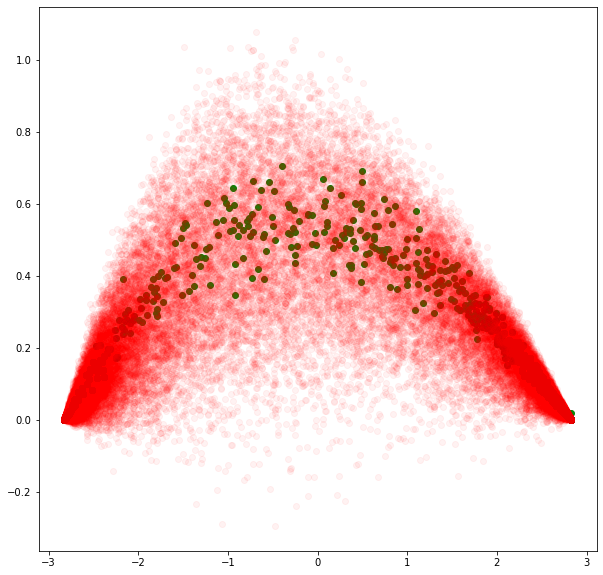

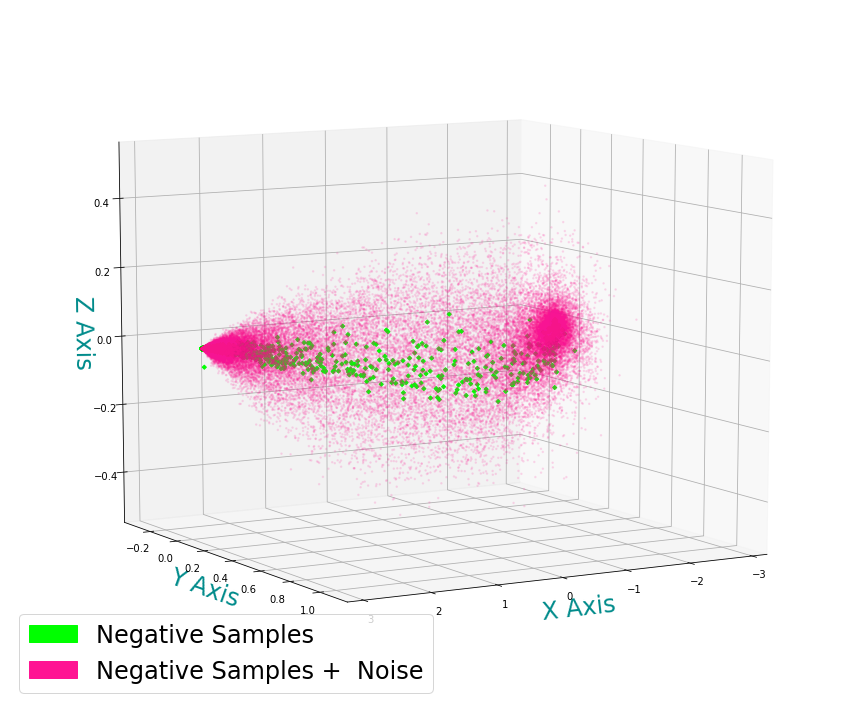

In [185]:
label_1='Negative Samples'
label_2='Negative Samples +  Noise'
title_text=None
# visualize(ae_model, x2 , x3 , color_1 ='orangered', color_2='chartreuse', label_1=label_1, label_2=label_2, title_text=title_text,figname='negative_samples1.jpg')
visualize(ae_model, x2 , x3 , color_1 ='lime', color_2='deeppink', label_1=label_1, label_2=label_2, title_text=title_text,figname='negative_samples1.jpg')


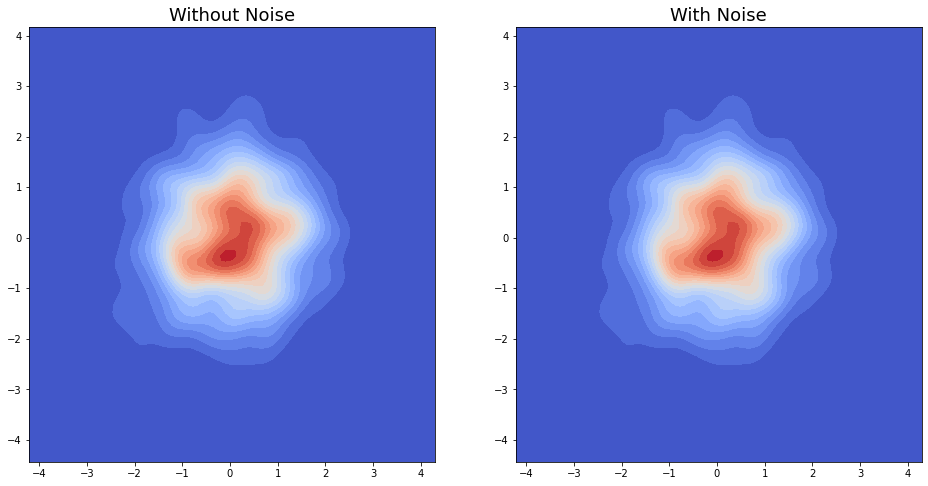

In [120]:
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(121)
ax = sns.kdeplot(noise[:1000,0], noise[:1000,1], n_levels=20, cmap="coolwarm",shade=True)
plt.title('Without Noise',fontsize=18)
ax = fig.add_subplot(122)
ax = sns.kdeplot(noise[:1000,0], noise[:1000,1], n_levels=20, cmap="coolwarm",shade=True)
plt.title('With Noise',fontsize=18)
plt.show()

In [139]:
def visualize2(model_obj, x1, x2, color_1=None, color_2=None, label_1=None, label_2=None, title_text=None,figname=None):
    from sklearn.decomposition import TruncatedSVD
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    x1 = np.array(x1)
    x2 = np.array(x2)
      
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1, x2])
    x3 = svd.fit_transform(x)
    
    # ----------------------------------------
    
    fig = plt.figure(figsize=[10, 5])
#     plt.ylabel('Y-axis',fontsize=18)
#     plt.ylabel('Y-axis',fontsize=18)

    count = x1.shape[0]
    ax = fig.add_subplot(121)
    ax = sns.kdeplot(x3[:count, 0][:10000], x3[:count, 1][:10000], n_levels=5, cmap="Blues_d",shade=False)
    plt.title(label_1,fontsize=18)
    ax = fig.add_subplot(122)
    ax = sns.kdeplot(x3[count:, 0][:10000], x3[count:, 1][:10000], n_levels=5, cmap="Blues_d",shade=False)
    plt.title(label_2,fontsize=22)
    
#     plt.tight_layout()
#     try:
#         plt.savefig(figname, pad_inches=0.01, dpi=75)
#     except:
#         pass
    try:
        plt.show()
        plt.close()
    except:
        pass
    return

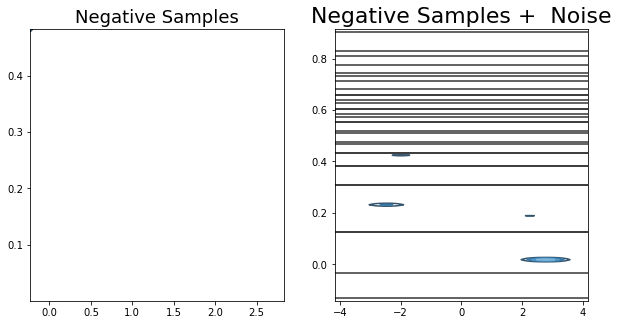

In [140]:
label_1='Negative Samples'
label_2='Negative Samples +  Noise'
title_text=None
visualize2(ae_model, x2 , x3 , color_1 ='red', color_2='blue', label_1=label_1, label_2=label_2, title_text=title_text,figname='negative_samples_v2.jpg')

In [142]:
x3.shape

(680940, 116)

In [144]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

z1 = ae_model.get_compressed_embedding(x2)
z2 = ae_model.get_compressed_embedding(x3)

z1 = np.array(z1)
z2 = np.array(z2)

svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
z = np.vstack([z1, z2])
z3 = svd.fit_transform(z)

In [145]:
count = z1.shape[0]

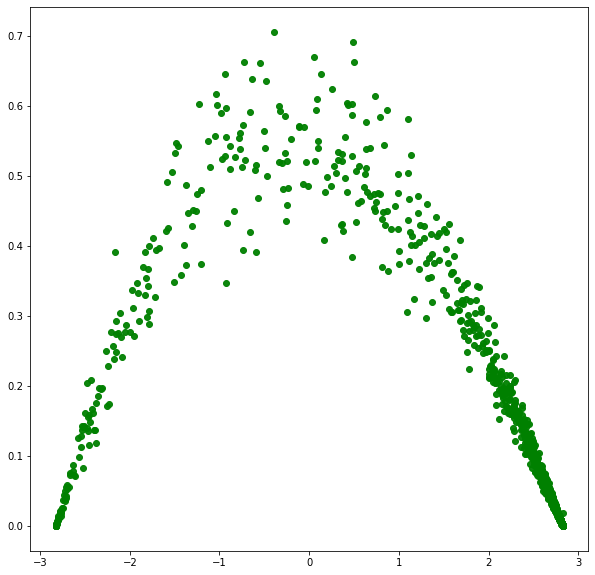

In [147]:
plt.figure(figsize=[10, 10])
plt.scatter(z3[:count, 0], z3[:count, 1], c='g', alpha=0.95)
# plt.scatter(z3[count:, 0], z3[count:, 1], c='r', alpha=0.35)
plt.show()

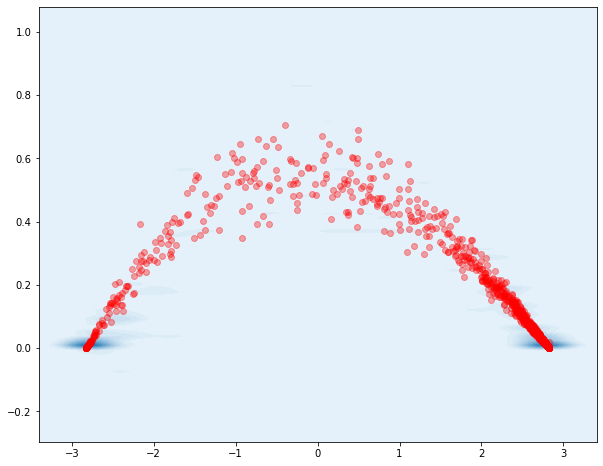

In [169]:
fig1 = plt.figure(figsize=[10, 8])
sns.kdeplot(z3[count:, 0], z3[count:, 1], n_levels=25, shade=True)
plt.scatter(z3[:count, 0], z3[:count, 1], c='r', alpha=0.35)
plt.show()

Text(0.5, 1.0, 'Negative Samples +  Noise')

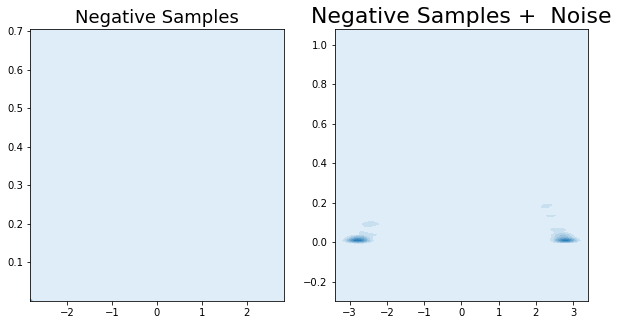

In [165]:
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(121)
ax1 = sns.kdeplot(z3[:count, 0], z3[:count, 1], n_levels=10,shade=True)
plt.title(label_1,fontsize=18)
ax2 = fig.add_subplot(122)
ax2 = sns.kdeplot(z3[count:, 0], z3[count:, 1], n_levels=10,shade=True)
plt.title(label_2,fontsize=22)

In [166]:
plt.show()

In [167]:
plt.savefig('viz_figure.png')

<Figure size 432x288 with 0 Axes>

In [186]:
x4 = np.array(pos)
noise = np.random.normal(loc=0.0, scale=1.0, size=x4.shape)
x5 = x4 + noise

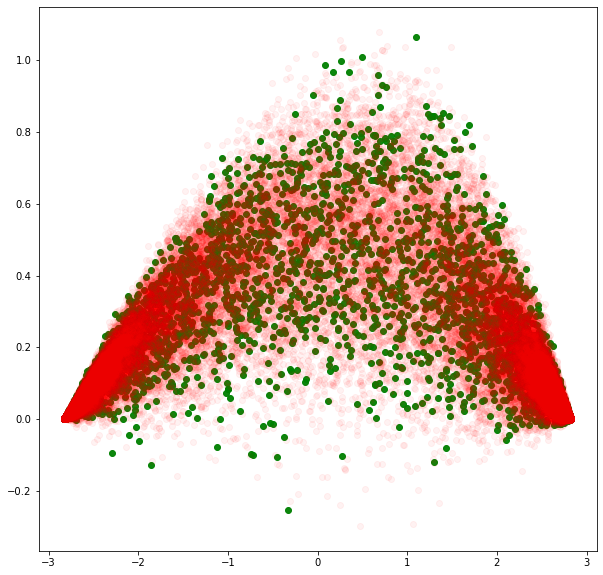

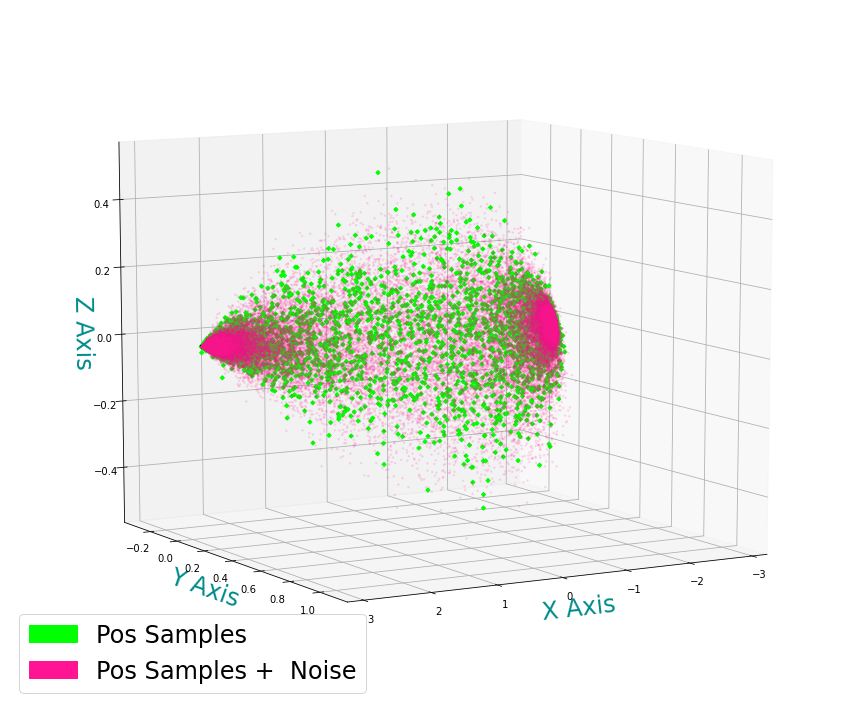

In [188]:
label_1='Pos Samples'
label_2='Pos Samples +  Noise'
title_text=None
# visualize(ae_model, x2 , x3 , color_1 ='orangered', color_2='chartreuse', label_1=label_1, label_2=label_2, title_text=title_text,figname='negative_samples1.jpg')
visualize(ae_model, x5 , x3 , color_1 ='lime', color_2='deeppink', label_1=label_1, label_2=label_2, title_text=title_text,figname='pos_samples1.jpg')
